In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path (change the path if necessary)
dataset_path = "/content/drive/My Drive/AFPILD_v1"
modified_dataset_path = "/content/drive/My Drive/AFPILD_Modified"

# Create a folder for modified dataset if it doesn't exist
os.makedirs(modified_dataset_path, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob

# Get list of all audio files from all subject folders
audio_files = glob.glob(dataset_path + "/S*/**/*.wav", recursive=True)

# Print number of files found
print(f"Found {len(audio_files)} footstep audio files.")


Found 160 footstep audio files.


In [ ]:
!pip install librosa numpy scipy


In [ ]:
import librosa
import numpy as np
import soundfile as sf

def add_gaussian_noise(audio, noise_level=0.02):
    noise = np.random.normal(0, noise_level, audio.shape)
    return audio + noise

# Test on one sample
sample_audio, sr = librosa.load(audio_files[0], sr=None)
noisy_audio = add_gaussian_noise(sample_audio)

# Save modified file
sf.write(modified_dataset_path + "/noisy_sample.wav", noisy_audio, sr)


In [ ]:
from scipy.interpolate import interp1d

def time_warp(audio, factor=1.5):
    x = np.arange(len(audio))
    interp = interp1d(x, audio, kind='linear')
    new_x = np.linspace(0, len(audio)-1, int(len(audio) * factor))
    return interp(new_x)

warped_audio = time_warp(sample_audio, factor=0.8)  # Compress footsteps

# Save modified file
sf.write(modified_dataset_path + "/warped_sample.wav", warped_audio, sr)


In [ ]:
def introduce_missing_values(audio, missing_rate=0.1):
    corrupted_audio = audio.copy()
    missing_indices = np.random.choice(len(audio), int(len(audio) * missing_rate), replace=False)
    corrupted_audio[missing_indices] = 0
    return corrupted_audio

dropout_audio = introduce_missing_values(sample_audio, missing_rate=0.2)

# Save modified file
sf.write(modified_dataset_path + "/dropout_sample.wav", dropout_audio, sr)


In [ ]:
def mix_footsteps(audio1, audio2, mix_ratio=0.5):
    min_length = min(len(audio1), len(audio2))
    return mix_ratio * audio1[:min_length] + (1 - mix_ratio) * audio2[:min_length]

# Load two different footstep samples
sample_audio_2, _ = librosa.load(audio_files[1], sr=None)
mixed_audio = mix_footsteps(sample_audio, sample_audio_2)

# Save modified file
sf.write(modified_dataset_path + "/mixed_sample.wav", mixed_audio, sr)


In [ ]:
import os

# Process all files
for file in audio_files:
    audio, sr = librosa.load(file, sr=None)

    # Apply all anomalies
    noisy_audio = add_gaussian_noise(audio)
    warped_audio = time_warp(audio, factor=0.8)
    dropout_audio = introduce_missing_values(audio, missing_rate=0.2)

    # Save files
    base_name = os.path.basename(file)
    sf.write(f"{modified_dataset_path}/noisy_{base_name}", noisy_audio, sr)
    sf.write(f"{modified_dataset_path}/warped_{base_name}", warped_audio, sr)
    sf.write(f"{modified_dataset_path}/dropout_{base_name}", dropout_audio, sr)

print("✅ Anomalies applied to all footstep files!")


✅ Anomalies applied to all footstep files!


In [ ]:
import shutil

# Zip the modified dataset
shutil.make_archive("/content/AFPILD_Modified", 'zip', modified_dataset_path)

# Provide download link
from google.colab import files
files.download("/content/AFPILD_Modified.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import zipfile
import librosa
import numpy as np

# Path to the ZIP file
zip_path = "AFPILD_Modified.zip"
extract_path = "AFPILD_Modified"

# Extract if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Now list files correctly
audio_files = [f for f in os.listdir(extract_path) if f.endswith(".wav")]
print(f"✅ Found {len(audio_files)} audio files in {extract_path}")

# Function to extract Mel spectrogram with padding
def extract_mel_spectrogram(audio_path, max_length=128):
    y, sr = librosa.load(audio_path, sr=None)

    # Compute Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec = (mel_spec - np.min(mel_spec)) / (np.max(mel_spec) - np.min(mel_spec))


    # Padding or truncating to max_length
    if mel_spec.shape[1] < max_length:
        pad_width = max_length - mel_spec.shape[1]
        mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec = mel_spec[:, :max_length]

    return mel_spec

# Extract features from all audio files
mel_spectrograms = []
for file in audio_files:
    file_path = os.path.join(extract_path, file)
    mel_spec = extract_mel_spectrogram(file_path)
    mel_spectrograms.append(mel_spec)

# Convert to numpy array with correct shape for deep learning
mel_spectrograms = np.array(mel_spectrograms)[:, np.newaxis, :, :]  # Add channel dimension

import librosa

def extract_log_mel_spectrogram(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to log scale
    return log_mel_spec


print(f"✅ Extracted and padded Mel spectrograms: {mel_spectrograms.shape}")



✅ Found 644 audio files in AFPILD_Modified
✅ Extracted and padded Mel spectrograms: (644, 1, 128, 128)
✅ Found 644 audio files in AFPILD_Modified
✅ Extracted and padded Mel spectrograms: (644, 1, 128, 128)


Normal Features: (160, 16)
Anomalous Features: (644, 16)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


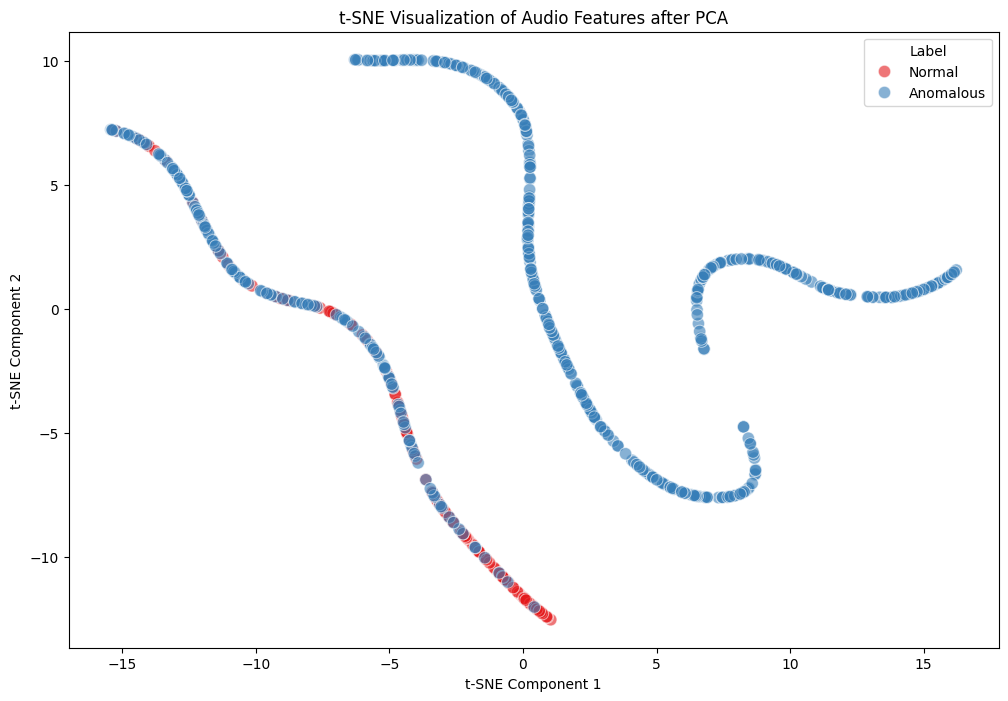

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths
normal_data_path = "/content/drive/MyDrive/AFPILD_v1"
anomalous_data_path = "/content/drive/MyDrive/AFPILD_Modified"

# Function to extract features
def extract_features(data_path, label):
    features = []

    # Use os.walk to go through all subdirectories
    files = []
    for dirpath, dirnames, filenames in os.walk(data_path):
        for file in filenames:
            if file.endswith(".wav"):
                files.append(os.path.join(dirpath, file))

    if not files:
        print(f"No .wav files found in {data_path}")

    for file in files:
        # Load the audio file
        y, sr = librosa.load(file, sr=None)

        # Extract features
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        zero_crossings = np.sum(librosa.zero_crossings(y))

        # Append features with label
        features.append([spectral_centroid, zero_crossings, *mfcc, label])

    return pd.DataFrame(features, columns=["Spectral Centroid", "Zero Crossings"] + [f"MFCC_{i}" for i in range(13)] + ["Label"])

# Get features from both datasets
normal_features = extract_features(normal_data_path, "Normal")
anomalous_features = extract_features(anomalous_data_path, "Anomalous")

# Check if the datasets are populated
print(f"Normal Features: {normal_features.shape}")
print(f"Anomalous Features: {anomalous_features.shape}")

# Combine normal and anomalous features into one DataFrame
data = pd.concat([normal_features, anomalous_features], ignore_index=True)

# Perform PCA for dimensionality reduction (reduce to 50 components)
X = data.drop(columns=["Label"])
y = data["Label"]

pca = PCA(n_components=10)  # Reduce to 10 components
X_pca = pca.fit_transform(X)

# Perform t-SNE on the reduced PCA data
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=300)
X_tsne = tsne.fit_transform(X_pca)

# Create a DataFrame with the t-SNE results
tsne_data = pd.DataFrame(X_tsne, columns=["t-SNE Component 1", "t-SNE Component 2"])
tsne_data["Label"] = y

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tsne_data, x="t-SNE Component 1", y="t-SNE Component 2", hue="Label", palette="Set1", s=80, alpha=0.6)
plt.title("t-SNE Visualization of Audio Features after PCA")
plt.show()


In [ ]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.6626 - loss: 3.8673 - val_accuracy: 0.8012 - val_loss: 0.4305 - learning_rate: 1.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.7922 - loss: 0.4946 - val_accuracy: 0.8012 - val_loss: 0.3040 - learning_rate: 1.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.7962 - loss: 0.4241 - val_accuracy: 0.9938 - val_loss: 0.1891 - learning_rate: 1.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.8516 - loss: 0.3183 - val_accuracy: 0.9938 - val_loss: 0.1151 - learning_rate: 1.0000e-04
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.8820 - loss: 0.2327 - val_accuracy: 0.9938 - val_loss: 0.0852 - learning_rate: 1.0000e-04
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.8602 - loss: 0.2042 - val_accuracy: 0.9938 - val_loss: 0.0687 - learning_rate: 1.0000e-04
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.8542 

Accuracy: 0.9938
Precision: 1.0000
Recall: 0.9922
F1-Score: 0.9961


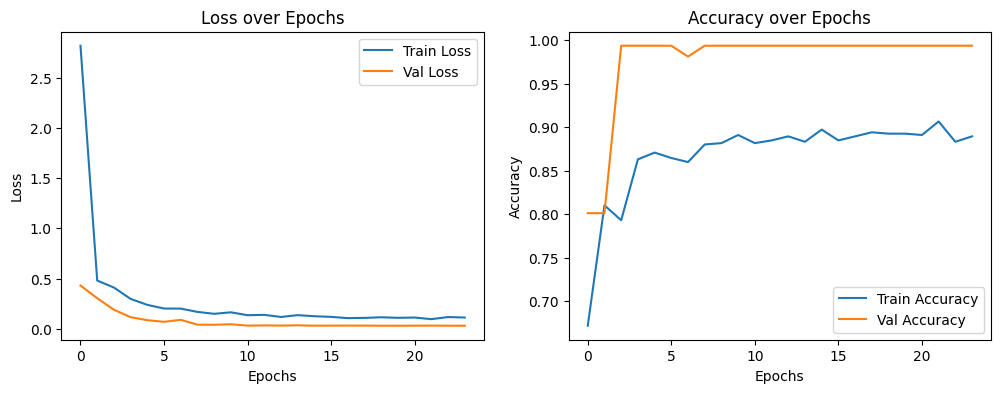

In [ ]:
import os
import numpy as np
import librosa
import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Data paths for AFPILD v1 and modified dataset
normal_data_path = '/content/drive/MyDrive/AFPILD_v1'
anomalous_data_path = '/content/drive/MyDrive/AFPILD_Modified'

# Set a fixed length for mel spectrograms
FIXED_LENGTH = 500 # Desired length of mel spectrograms
N_MELS = 128        # Number of mel frequency bins

# Function to load audio files and extract features
def extract_features(audio_file):
    y, sr = librosa.load(audio_file, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Fix length properly to ensure uniform size
    mel_spectrogram_db = librosa.util.fix_length(mel_spectrogram_db, size=FIXED_LENGTH, axis=1)

    return mel_spectrogram_db.T  # Transpose to (500, 128)

# Function to process all data from directories and label them
def process_data(normal_path, anomalous_path):
    normal_files = glob.glob(normal_path + '/**/*.wav', recursive=True)
    anomalous_files = glob.glob(anomalous_path + '/**/*.wav', recursive=True)

    data = []
    labels = []

    # Process normal files
    for file in normal_files:
        features = extract_features(file)
        data.append(features)
        labels.append(0)  # Normal footstep labeled as 0

    # Process anomalous files
    for file in anomalous_files:
        features = extract_features(file)
        data.append(features)
        labels.append(1)  # Anomalous footstep labeled as 1

    return np.array(data), np.array(labels)

# Load and preprocess the dataset
X, y = process_data(normal_data_path, anomalous_data_path)

# Reshape for CNN input (adding an additional channel dimension)
X = np.expand_dims(X, axis=-1)  # Shape should be (num_samples, 500, 128, 1)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a simple CNN model with early stopping and learning rate reduction
def build_model():
    inputs = layers.Input(shape=(FIXED_LENGTH, N_MELS, 1))

    # Conv Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Conv Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Conv Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Fully connected layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    # Output Layer
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create model
    model = models.Model(inputs, outputs)
    return model

# Compile and build the model
model = build_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the Model with a lower number of epochs (30 epochs max for faster results)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate Model Performance on Validation Set
y_pred = (model.predict(X_val) > 0.5).astype("int32")
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Save the trained model for testing later
model.save('improved_footstep_model.h5')

# Plot Training Results (Loss and Accuracy over Epochs)
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


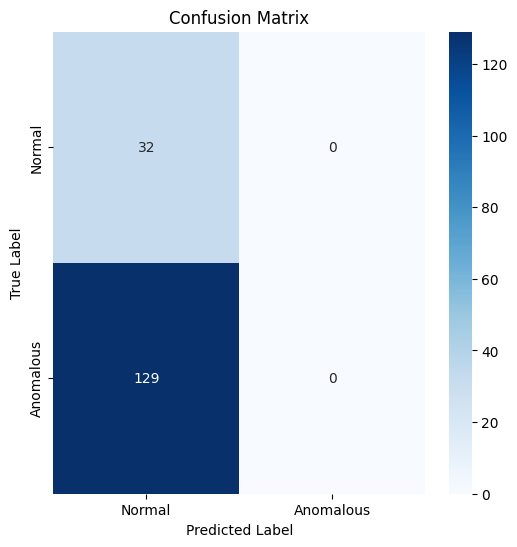

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the true labels y_val and predicted labels y_pred_classes
cm = confusion_matrix(y_val, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()



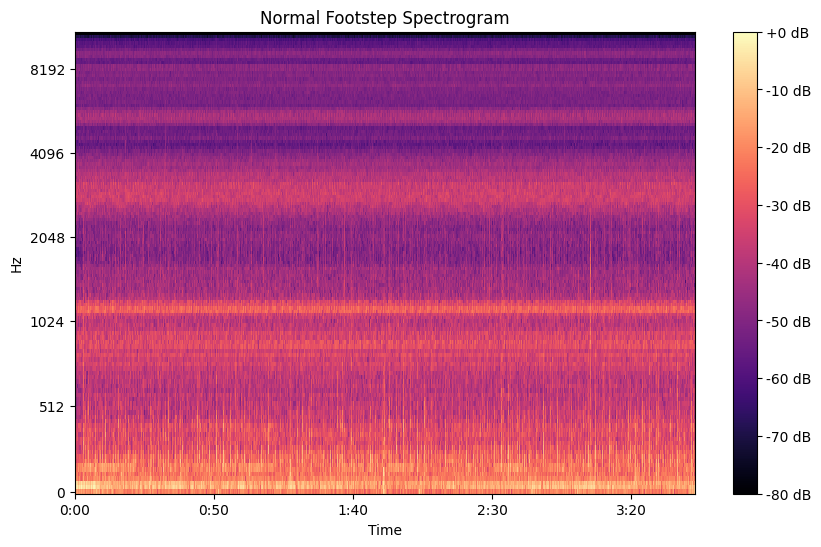

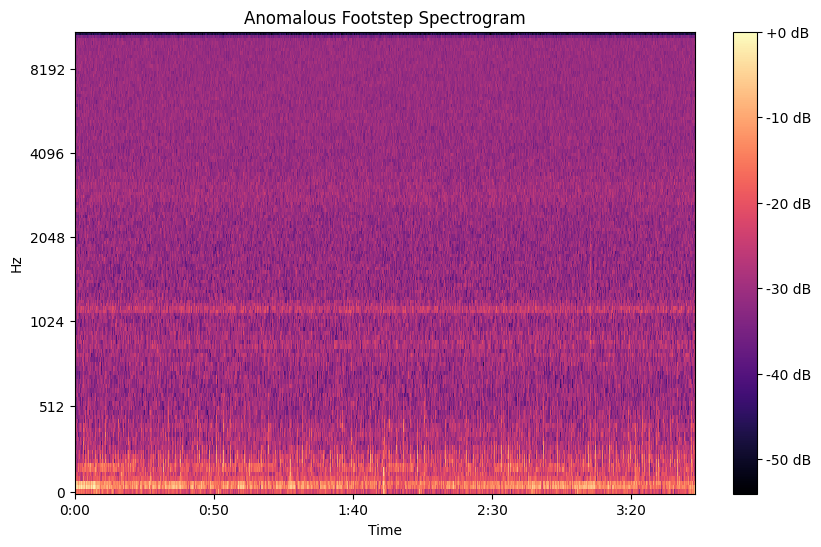

In [ ]:
import librosa.display

# Visualize Spectrogram of a normal footstep
normal_file = '/content/drive/MyDrive/AFPILD_v1/S14/s14_4_footstep_audio.wav'
y, sr = librosa.load(normal_file)
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Normal Footstep Spectrogram')
plt.show()

# Visualize Spectrogram of an anomalous (noisy) footstep
anomalous_file = '/content/drive/MyDrive/AFPILD_Modified/noisy_s14_4_footstep_audio.wav'
y_anomalous, sr_anomalous = librosa.load(anomalous_file)
mel_spectrogram_anomalous = librosa.feature.melspectrogram(y=y_anomalous, sr=sr_anomalous, n_mels=128, fmax=8000)
mel_spectrogram_db_anomalous = librosa.power_to_db(mel_spectrogram_anomalous, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spectrogram_db_anomalous, x_axis='time', y_axis='mel', sr=sr_anomalous)
plt.colorbar(format='%+2.0f dB')
plt.title('Anomalous Footstep Spectrogram')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Get classification report for Normal vs Anomalous
report = classification_report(y_val, y_pred_classes, target_names=['Normal', 'Anomalous'])
print(report)


              precision    recall  f1-score   support

      Normal       0.20      1.00      0.33        32
   Anomalous       0.00      0.00      0.00       129

    accuracy                           0.20       161
   macro avg       0.10      0.50      0.17       161
weighted avg       0.04      0.20      0.07       161



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
